<h1> <img style="height:5em;" alt="batty" src="https://raw.githubusercontent.com/philippeller/batty/main/batty_logo.svg"/> </h1> 

# BAT to Python (batty)

A small python interface to the Bayesian Analysis Toolkit (BAT.jl) https://github.com/bat/BAT.jl


* Please check out the minimal example to get started [below](#minimal-example)
* To understand how to define a prior + likelihood, please read [this](#specifying-priors-and-likelihoods)
* For experimental support of gradients, see [this](#hmc-with-gradients)

# Quick Start

## Installation

There are two parts to an installation, one concerning the python side, and one the julia side:

* Python: `pip install batty`

* Julia: `import Pkg; Pkg.add(["PyJulia", "DensityInterface", "Distributions", "ValueShapes", "TypedTables", "ArraysOfArrays", "ChainRulesCore", "BAT"])`

sampler.findmodeExample

The code below is showing a minimal example:
* using a gaussian likelihood and a uniform prior
* generating samples via Metropolis-Hastings
* plotting the resulting sampes
* <s>estimating the integral value via BridgeSampling</s>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from batty import BAT_sampler, BAT, Distributions, jl
import juliacall

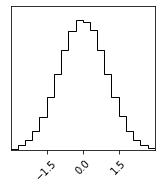

In [3]:
sampler = BAT_sampler(llh=lambda x : -0.5 * x**2, prior_specs=Distributions.Uniform(-3, 3))
sampler.sample();
sampler.corner();

# Usage

## Using Different Algotihms

There are a range of algorihtms available within BAT, and those can be further customized via arguments. Here are just a few examples:

### MCMC Sampling:

In [4]:
results = {}

* Metropolis-Hastings:

In [5]:
results['Metropolis-Hastings'] = sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2))

* Metropolis-Hastings with Accept-Reject weighting:

In [6]:
results['Accept-Reject Weighting'] = sampler.sample(strategy=BAT.MCMCSampling(mcalg=BAT.MetropolisHastings(weighting=BAT.ARPWeighting()), nsteps=10_000, nchains=2))

* Prior Importance Sampling:

In [7]:
results['Prior Importance Sampling'] = sampler.sample(strategy=BAT.PriorImportanceSampler(nsamples=10_000))

* Sobol Sampler:

In [8]:
results['Sobol Quasi Random Numbers'] = sampler.sample(strategy=BAT.SobolSampler(nsamples=10_000))

* Grid Sampler:

In [9]:
results['Grid Points'] = sampler.sample(strategy=BAT.GridSampler(ppa=1000))

Plotting the different results:

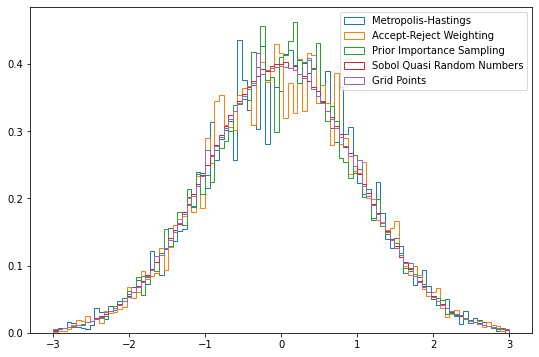

In [10]:
fig = plt.figure(figsize=(9,6))
bins=np.linspace(-3, 3, 100)
for key, item in results.items():
    plt.hist(item.v, weights=item.weight, bins=bins, density=True, histtype="step", label=key);
plt.legend()

# Specifying Priors and Likelihoods

Priors are specified via Julia `Distributions`, multiple Dimensions can be defined via a `dict`, where the `key` is the dimension name and the value the distribution, or as a list in case flat vectors with paraeter names are used.

Below the example *with* parameter names

In [11]:
s = np.array([[0.25, 0.4], [0.9, 0.75]])
prior_specs = {'a' : Distributions.Uniform(-3,3), 'b' : Distributions.MvNormal(np.array([1.,1.]), jl.Array(s@s.T))}

The log-likelihood (`llh`) can be any python callable, that returns the log-likelihood values. The first argument to the function is the object with paramneter values, here `x`. If the prior is simple (i.e. like in the example in the beginning, `x` is directly the parameter value). If the prior is specified via a `dict`, then `x` contains a field per parameter with the value.
Any additional `args` to the llh can be given in the sampler, such as here `d` for data:

In [12]:
def llh(x, d):
    return -0.5 * ((x.b[0] - d[0])**2 + (x.b[1] - d[1])**2/4) - x.a

Or alternatively *without* parameter names (this will result in a flat vector):

In [13]:
prior_specs = [Distributions.Uniform(-3,3), Distributions.MvNormal(np.array([1.,1.]), jl.Array(s@s.T))]
def llh(x, d):
    return -0.5 * ((x[1] - d[0])**2 + (x[2] - d[1])**2/4) - x[0]

In [14]:
d = [-1, 1]

In [15]:
sampler = BAT_sampler(llh=llh, prior_specs=prior_specs, llh_args=(d,))

Let us generate a few samples:

In [16]:
sampler.sample(strategy=BAT.MCMCSampling(nsteps=10_000, nchains=2));

### Some interface to plotting tools are available

* The **G**reat **T**riangular **C**onfusion (GTC) plot:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


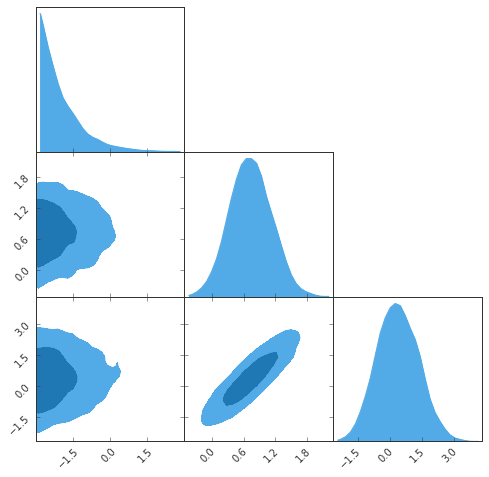

In [17]:
sampler.gtc(figureSize=8, customLabelFont={'size':14}, customTickFont={'size':10});

* The corner plot:

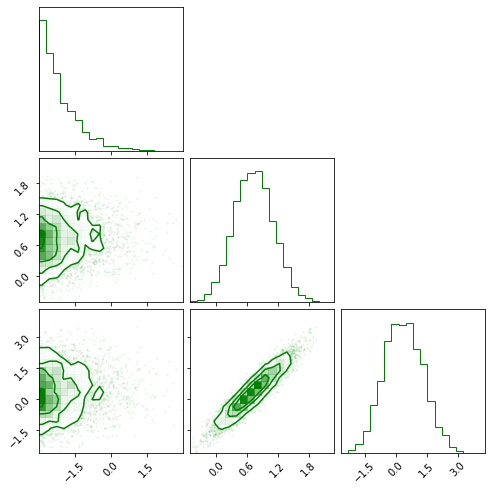

In [18]:
sampler.corner(color='green');

## HMC with Gradients

This at the moment only works with preiors defined as flat vectors!

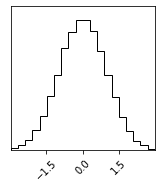

In [19]:
llh = lambda x : -0.5 * np.dot(x, x)
grad = lambda x : -x
sampler = BAT_sampler(llh=llh, prior_specs=[Distributions.Uniform(-3, 3),], grad=grad, )

# Or alternatively:
# llh_and_grad = lambda x: (-0.5 * np.dot(x, x), -x)
# sampler = BAT_sampler(llh=llh, prior_specs=[Distributions.Uniform(-3, 3),], llh_and_grad=llh_and_grad)

sampler.sample(strategy=BAT.MCMCSampling(mcalg=BAT.HamiltonianMC()));
sampler.corner();

In [20]:
sampler.findmode()

(result = [5.210924046524456e-5], result_trafo = [5.210924046524456e-5], trafo = identity ∘ identity, trace_trafo = NamedTuple{(:v,), Tuple{Vector{Float64}}}[(v = [-2.1581073465187135],), (v = [-2.1581073465187135],), (v = [1.004053673259357],), (v = [0.2135134183148394],), (v = [0.01587835457870998],), (v = [0.01587835457870998],), (v = [0.003526163095201894],), (v = [0.00043811522432487225],), (v = [-0.00033389674339438314],), (v = [-0.0001408937514645693],)], info = Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [-2.1581073465187135]
 * Maximizer: [5.210924046524456e-5]
 * Maximum: -1.791759e+00
 * Iterations: 9
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 21, optargs = (algorithm = NelderMeadOpt{DoNotTransform, InitFromTarget}
  trafo: DoNotTransform DoNotTransform()
  init: InitFromTarget InitFromTarget()
,), kwargs = NamedTuple())